<a href="https://colab.research.google.com/github/AVIGROUP/AI-apple/blob/main/Leonardo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup as bs

import yfinance as yf

import datetime
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.svm import SVR

!pip install yfinance

'''
  current_time -- текущая дата

  month_span -- за сколько месяцев парсить данные с сайта

  month_start -- номер месяца, с которого начинать парсинг

  date_start -- дата начала парсинга

  data_AAPL -- датафрейм со всеми данными с сайта yahoo по акциям AAPL (apple)
'''
# преобразование столбца с временем, чтобы в последствии отсчитывать 3 месяца
# изменения акции в цене
current_time = datetime.datetime.now().date()
month_span = 3
month_start = '%02d'%(12 - month_span + current_time.month + 1)

# если окажется, что диапазон даты прасинга затрагивает прошлый год,
# то изменяется год даты начала парсинга
if current_time.month - month_span < 0:
  start_year = current_time.year - 1
else:
  start_year = current_time.year

# приводим время к нужному виду
date_start = str(start_year) + '-' + str(month_start) + '-' + str(current_time.day)

# используя методы библиотеки от Yahoo загружаем данные за интересующий период
data_AAPL = yf.download('AAPL', start=date_start, end=current_time)
print('\n' + 'Текущие данные имеют следующий вид:')
display(data_AAPL.round(2))

df = data_AAPL
df.reset_index(inplace=True)

# вычисление максимального отклонения вниз и вверх на 4%
# считается отдельно для каждой строки / каждого дня
df['Max Down'] = df['Close'].rolling(window=10).min() - df['Open'].rolling(window=4).min() * 0.04
df['Max Up'] = df['Close'].rolling(window=10).max() - df['Open'].rolling(window=4).max() * 0.04
df[['Max Down', 'Max Up']]
print('\n' + 'Максимальное отклонение вниз и вверх на 4%:')
display(df.round(2))


# plt.figure()
# plt.plot(data_AAPL["Close"], label="CLOSE")
# plt.plot(df["Max Down"], label="DOWN")
# plt.plot(df["Max Up"], label="UP")

# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.legend()
# plt.show()


# запись данных из датафрейма с отклонениями вверх и вниз
file_name = str(date_start) + '_till_' + str(current_time) + '.xlsx'
df.to_excel(file_name)

# подсчет дельты, чтобы понять, цена упала или возросла
df['Delta'] = df['Close'] - df['Open']
df = df.fillna(0)
df['Delta_1'] = df['Delta'].rolling(window=10).mean()


# plt.figure()
# plt.plot(data_AAPL["Delta"], label="CLOSE")
# plt.plot(df["Delta_1"], label="Delta")

# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.legend()
# plt.show()


# если Open > Close, то цена упала, значение соответствует 0, в противном случае цена возрасла и соответствует 1
df['delta_sign'] = df['Delta'].apply(lambda x: 1 if x > 0 else 0)



# NAIVE BAYES
# в качестве таргетной переменной используется дельта, которая содержит 0 и 1 для
# более удобной классификации
print('\n'+ 'NAIVE BAYES')
df['Delta'] = df['Close'] - df['Open']
df = df.fillna(0)
df['Delta_1'] = df['Delta'].rolling(window=10).mean()
df['delta_sign'] = df['Delta'].apply(lambda x: 1 if x > 0 else 0)

X = df.drop([ 'Delta_1', 'delta_sign', 'Date', 'Volume'], axis=1)
y = df['delta_sign']

# saving first df
temp_df = df.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 19)

model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print(y_pred)
df_1 = pd.DataFrame(X_test, columns=None)
df_1['pred'] = y_pred
df_1 = df_1.reset_index(drop=True)
print('Предсказание pred с использованием наивного байеса:' + '\n')
# adding Date
col = temp_df['Date']
df_1['Date'] = col

display(df_1.round(2))

# SVM
# используемое ядро - гауссиан
print('\n'+ 'SVM - RBF KERNEL')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 19)

svr_rbf = SVR(kernel='rbf', C=100, gamma='auto')
svr_rbf.fit(X_train, y_train)

y_pred = svr_rbf.predict(X_test)

df_1['pred_RBF'] = df_1['Open'] + y_pred
print('Предсказание pred_RBF с использованием SVM:' + '\n')
display(df_1.round(2))

[*********************100%%**********************]  1 of 1 completed


Текущие данные имеют следующий вид:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-18,196.09,196.63,194.39,195.89,195.64,55751900
2023-12-19,196.16,196.95,195.89,196.94,196.69,40714100
2023-12-20,196.90,197.68,194.83,194.83,194.58,52242800
2023-12-21,196.10,197.08,193.50,194.68,194.43,46482500
2023-12-22,195.18,195.41,192.97,193.60,193.35,37122800
2023-12-26,193.61,193.89,192.83,193.05,192.80,28919300
2023-12-27,192.49,193.50,191.09,193.15,192.90,48087700
2023-12-28,194.14,194.66,193.17,193.58,193.33,34049900
2023-12-29,193.90,194.40,191.73,192.53,192.28,42628800



Максимальное отклонение вниз и вверх на 4%:


,Date,Open,High,Low,Close,Adj Close,Volume,Max Down,Max Up
0,2023-12-18,196.09,196.63,194.39,195.89,195.64,55751900,NaN,NaN
1,2023-12-19,196.16,196.95,195.89,196.94,196.69,40714100,NaN,NaN
2,2023-12-20,196.90,197.68,194.83,194.83,194.58,52242800,NaN,NaN
3,2023-12-21,196.10,197.08,193.50,194.68,194.43,46482500,NaN,NaN
4,2023-12-22,195.18,195.41,192.97,193.60,193.35,37122800,NaN,NaN
5,2023-12-26,193.61,193.89,192.83,193.05,192.80,28919300,NaN,NaN
6,2023-12-27,192.49,193.50,191.09,193.15,192.90,48087700,NaN,NaN
7,2023-12-28,194.14,194.66,193.17,193.58,193.33,34049900,NaN,NaN
8,2023-12-29,193.90,194.40,191.73,192.53,192.28,42628800,NaN,NaN
9,2024-01-02,187.15,188.44,183.89,185.64,185.40,82488700,178.15,189.17



NAIVE BAYES
Предсказание pred с использованием наивного байеса:



,Open,High,Low,Close,Adj Close,Max Down,Max Up,Delta,pred,Date
0,183.92,185.15,182.73,185.14,184.90,173.90,186.22,1.22,1,2023-12-18
1,195.22,196.27,193.11,194.17,193.92,174.99,187.36,-1.05,0,2023-12-19
2,182.09,185.60,181.50,185.56,185.32,173.90,186.23,3.47,1,2023-12-20
3,189.33,191.95,188.82,191.56,191.32,173.93,183.99,2.23,1,2023-12-21
4,183.42,184.85,181.67,182.31,182.31,174.97,181.98,-1.11,1,2023-12-22
5,192.49,193.50,191.09,193.15,192.90,0.00,0.00,0.66,0,2023-12-26
6,185.32,185.53,182.44,184.15,184.15,176.74,181.86,-1.17,1,2023-12-27
7,196.16,196.95,195.89,196.94,196.69,0.00,0.00,0.78,0,2023-12-28
8,196.09,196.63,194.39,195.89,195.64,0.00,0.00,-0.20,0,2023-12-29
9,188.15,189.25,185.84,187.68,187.44,177.21,187.65,-0.47,1,2024-01-02



SVM - RBF KERNEL
Предсказание pred_RBF с использованием SVM:



,Open,High,Low,Close,Adj Close,Max Down,Max Up,Delta,pred,Date,pred_RBF
0,183.92,185.15,182.73,185.14,184.90,173.90,186.22,1.22,1,2023-12-18,184.60
1,195.22,196.27,193.11,194.17,193.92,174.99,187.36,-1.05,0,2023-12-19,195.39
2,182.09,185.60,181.50,185.56,185.32,173.90,186.23,3.47,1,2023-12-20,182.65
3,189.33,191.95,188.82,191.56,191.32,173.93,183.99,2.23,1,2023-12-21,189.82
4,183.42,184.85,181.67,182.31,182.31,174.97,181.98,-1.11,1,2023-12-22,184.04
5,192.49,193.50,191.09,193.15,192.90,0.00,0.00,0.66,0,2023-12-26,192.81
6,185.32,185.53,182.44,184.15,184.15,176.74,181.86,-1.17,1,2023-12-27,185.70
7,196.16,196.95,195.89,196.94,196.69,0.00,0.00,0.78,0,2023-12-28,196.60
8,196.09,196.63,194.39,195.89,195.64,0.00,0.00,-0.20,0,2023-12-29,196.38
9,188.15,189.25,185.84,187.68,187.44,177.21,187.65,-0.47,1,2024-01-02,188.51


In [ ]:
current_time = datetime.datetime.now().date()
month_span = 3
month_start = '%02d'%(12 - month_span + current_time.month)

# если окажется, что диапазон даты прасинга затрагивает прошлый год,
# то изменяется год даты начала парсинга
if current_time.month - month_span < 0:
  start_year = current_time.year - 1
else:
  start_year = current_time.year
start_year

2023

In [ ]:
current_time = datetime.datetime.now().date()
month_span = 3
month_start = '%02d'%(12 - month_span + current_time.month + 1)
current_time.month

2

#REQUEST

In [ ]:
import requests
from bs4 import BeautifulSoup as bs

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import datetime

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
'''
  current_time -- текущая дата

  month_span -- за сколько месяцев парсить данные с сайта

  month_start -- номер месяца, с которого начинать парсинг

  date_start -- дата начала парсинга

  data_AAPL -- датафрейм со всеми данными с сайта yahoo по акциям AAPL (apple)
'''

'\n  current_time -- текущая дата\n\n  month_span -- за сколько месяцев парсить данные с сайта\n\n  month_start -- номер месяца, с которого начинать парсинг\n\n  date_start -- дата начала парсинга\n\n  data_AAPL -- датафрейм со всеми данными с сайта yahoo по акциям AAPL (apple)\n'

## MODULE 1

In [ ]:
current_time = datetime.datetime.now().date()

month_span = 3

month_start = '%02d'%(12 - month_span + current_time.month)

# если окажется, что диапазон даты прасинга затрагивает прошлый год,
# то изменяется год даты начала парсинга
if current_time.month - month_span < 0:
  start_year = current_time.year - 1
else:
  start_year = current_time.year

date_start = str(start_year) + '-' + str(month_start) + '-' + str(current_time.day)

In [ ]:
data_AAPL = yf.download('AAPL', start=date_start, end=current_time)
data_AAPL.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-02,175.520004,177.779999,175.460007,177.570007,177.336380,77334800
2023-11-03,174.240005,176.820007,173.350006,176.649994,176.417572,79763700
2023-11-06,176.380005,179.429993,176.210007,179.229996,178.994186,63841300
2023-11-07,179.179993,182.440002,178.970001,181.820007,181.580780,70530000
2023-11-08,182.350006,183.449997,181.589996,182.889999,182.649368,49340300


## MODULE 2

In [ ]:
# type(data_AAPL)
# data_AAPL

In [ ]:
import pandas as pd

In [ ]:
df = data_AAPL
df.reset_index(inplace=True)

In [ ]:
df['Max Down'] = df['Close'].rolling(window=10).min() - df['Open'].rolling(window=4).min() * 0.04
df['Max Up'] = df['Close'].rolling(window=10).max() - df['Open'].rolling(window=4).max() * 0.04
df[['Max Down', 'Max Up']]
df

,Date,Open,High,Low,Close,Adj Close,Volume,Max Down,Max Up
0,2023-11-02,175.520004,177.779999,175.460007,177.570007,177.336380,77334800,NaN,NaN
1,2023-11-03,174.240005,176.820007,173.350006,176.649994,176.417572,79763700,NaN,NaN
2,2023-11-06,176.380005,179.429993,176.210007,179.229996,178.994186,63841300,NaN,NaN
3,2023-11-07,179.179993,182.440002,178.970001,181.820007,181.580780,70530000,NaN,NaN
4,2023-11-08,182.350006,183.449997,181.589996,182.889999,182.649368,49340300,NaN,NaN
...,...,...,...,...,...,...,...,...,...
57,2024-01-26,194.270004,194.759995,191.940002,192.419998,192.419998,44594000,174.909193,187.363193
58,2024-01-29,192.009995,192.199997,189.580002,191.729996,191.729996,47145600,174.999593,187.363193
59,2024-01-30,190.940002,191.800003,187.470001,188.039993,188.039993,55859400,175.042393,187.371193
60,2024-01-31,187.039993,187.100006,184.350006,184.399994,184.399994,55467800,176.918394,187.409193


## MODULE 3

In [ ]:
import matplotlib.pyplot as plt

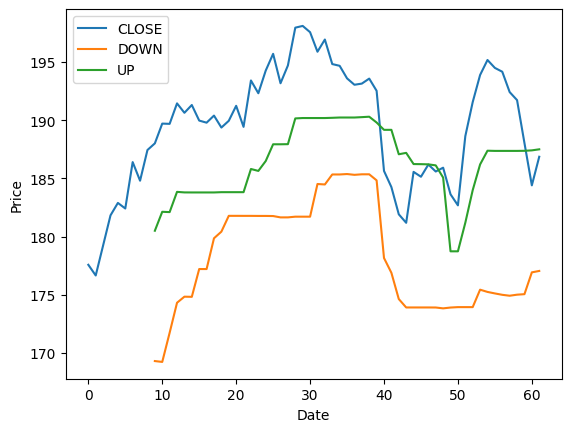

In [ ]:
plt.figure()
plt.plot(data_AAPL["Close"], label="CLOSE")
plt.plot(df["Max Down"], label="DOWN")
plt.plot(df["Max Up"], label="UP")

plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
file_name = str(date_start) + '_till_' + str(current_time) + '.xlsx'
df.to_excel(file_name)

# LEARNING | MODULE 4

## NAIVE BAYES

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Max Down,Max Up
0,2023-11-02,175.520004,177.779999,175.460007,177.570007,177.336380,77334800,NaN,NaN
1,2023-11-03,174.240005,176.820007,173.350006,176.649994,176.417572,79763700,NaN,NaN
2,2023-11-06,176.380005,179.429993,176.210007,179.229996,178.994186,63841300,NaN,NaN
3,2023-11-07,179.179993,182.440002,178.970001,181.820007,181.580780,70530000,NaN,NaN
4,2023-11-08,182.350006,183.449997,181.589996,182.889999,182.649368,49340300,NaN,NaN


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

In [ ]:
df['Delta'] = df['Close'] - df['Open']
df = df.fillna(0)
df['Delta_1'] = df['Delta'].rolling(window=10).mean()

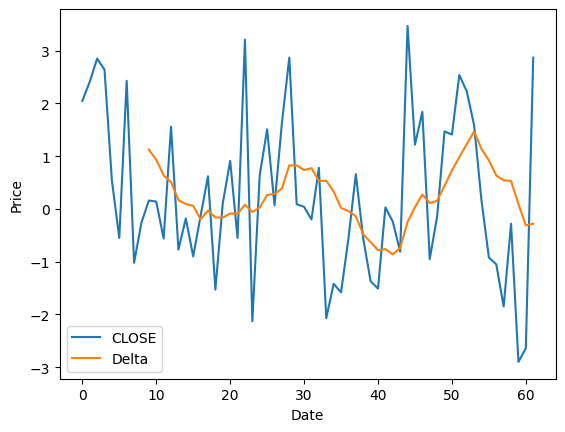

In [ ]:
plt.figure()
plt.plot(data_AAPL["Delta"], label="CLOSE")
plt.plot(df["Delta_1"], label="Delta")

plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
# если Open > Close, то цена упала, значение соответствует 0, в противном случае цена возрасла и соответствует 1

df['delta_sign'] = df['Delta'].apply(lambda x: 1 if x > 0 else 0)
df

,Date,Open,High,Low,Close,Adj Close,Volume,Max Down,Max Up,Delta,Delta_1,delta_sign
0,2023-11-02,175.520004,177.779999,175.460007,177.570007,177.336380,77334800,0.000000,0.000000,2.050003,NaN,1
1,2023-11-03,174.240005,176.820007,173.350006,176.649994,176.417572,79763700,0.000000,0.000000,2.409988,NaN,1
2,2023-11-06,176.380005,179.429993,176.210007,179.229996,178.994186,63841300,0.000000,0.000000,2.849991,NaN,1
3,2023-11-07,179.179993,182.440002,178.970001,181.820007,181.580780,70530000,0.000000,0.000000,2.640015,NaN,1
4,2023-11-08,182.350006,183.449997,181.589996,182.889999,182.649368,49340300,0.000000,0.000000,0.539993,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...
57,2024-01-26,194.270004,194.759995,191.940002,192.419998,192.419998,44594000,174.909193,187.363193,-1.850006,0.543997,0
58,2024-01-29,192.009995,192.199997,189.580002,191.729996,191.729996,47145600,174.999593,187.363193,-0.279999,0.529997,0
59,2024-01-30,190.940002,191.800003,187.470001,188.039993,188.039993,55859400,175.042393,187.371193,-2.900009,0.092996,0
60,2024-01-31,187.039993,187.100006,184.350006,184.399994,184.399994,55467800,176.918394,187.409193,-2.639999,-0.312003,0


In [ ]:
X = df.drop([ 'Delta_1', 'delta_sign', 'Date', 'Volume'], axis=1)
y = df['delta_sign']

In [ ]:
# X

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 19)

In [ ]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print(y_pred)
df_1 = pd.DataFrame(X_test, columns=None)
df_1['pred'] = y_pred
df_1 = df_1.reset_index(drop=True)
df_1

,Open,High,Low,Close,Adj Close,Max Down,Max Up,Delta,pred
0,190.899994,192.089996,188.970001,189.369995,189.369995,180.418795,183.813997,-1.529999,0
1,192.490005,193.500000,191.089996,193.149994,193.149994,185.350403,190.266000,0.659988,0
2,197.529999,198.399994,197.000000,197.570007,197.570007,181.706793,190.189200,0.040009,0
3,191.490005,192.929993,190.830002,191.309998,191.309998,174.814404,183.790397,-0.180008,0
4,187.039993,187.100006,184.350006,184.399994,184.399994,176.918394,187.409193,-2.639999,0
5,193.080002,194.720001,191.720001,194.710007,194.710007,181.646795,187.942007,1.630005,1
6,183.970001,186.570007,183.529999,186.399994,186.399994,0.000000,0.000000,2.429993,1
7,186.539993,187.050003,183.619995,185.589996,185.589996,173.896393,186.118402,-0.949997,0
8,181.990005,182.759995,180.169998,181.179993,181.179993,173.900392,187.193993,-0.810013,1
9,194.270004,194.759995,191.940002,192.419998,192.419998,174.909193,187.363193,-1.850006,0


## SVM

In [ ]:
from sklearn.svm import SVR

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 19)

In [ ]:
svr_rbf = SVR(kernel='rbf', C=100, gamma='auto')
svr_rbf.fit(X_train, y_train)

SVR(C=100, gamma='auto')

In [ ]:
y_pred = svr_rbf.predict(X_test)

In [ ]:
df_1['pred_RBF'] = df_1['Open'] + y_pred
df_1

,Open,High,Low,Close,Adj Close,Max Down,Max Up,Delta,pred,pred_RBF
0,190.899994,192.089996,188.970001,189.369995,189.369995,180.418795,183.813997,-1.529999,0,191.372535
1,192.490005,193.500000,191.089996,193.149994,193.149994,185.350403,190.266000,0.659988,0,192.881894
2,197.529999,198.399994,197.000000,197.570007,197.570007,181.706793,190.189200,0.040009,0,198.391862
3,191.490005,192.929993,190.830002,191.309998,191.309998,174.814404,183.790397,-0.180008,0,191.978838
4,187.039993,187.100006,184.350006,184.399994,184.399994,176.918394,187.409193,-2.639999,0,187.483518
5,193.080002,194.720001,191.720001,194.710007,194.710007,181.646795,187.942007,1.630005,1,193.848345
6,183.970001,186.570007,183.529999,186.399994,186.399994,0.000000,0.000000,2.429993,1,184.493440
7,186.539993,187.050003,183.619995,185.589996,185.589996,173.896393,186.118402,-0.949997,0,187.143898
8,181.990005,182.759995,180.169998,181.179993,181.179993,173.900392,187.193993,-0.810013,1,182.213826
9,194.270004,194.759995,191.940002,192.419998,192.419998,174.909193,187.363193,-1.850006,0,194.747394
